In [1]:
import sys,os
os.chdir('../../')
sys.path.append('./src/data')
sys.path.append('./src/events')
sys.path.append('./src/probability')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from IC.importer import *
from IC.processer import *
from IC.main import sim_events, list_of_params
from functions import ic_params_nsi,perform_chisq
from scipy.stats import chi2
from IC.event_processing import *
from DC.event_processing import list_of_params_nsi,get_param_list, get_best_fit, nufit_params_nsi_IO,nufit_params_nsi,get_marginalized_array
import pickle
from multiprocessing import Pool
from src.plotter import save, savethesis
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 100
matplotlib.rc('text', usetex=True)
matplotlib.rc('text.latex', preamble=r'\usepackage{amsmath}')
np.set_printoptions(linewidth=200)
np.set_printoptions(suppress=True)

giunti_contour_cl90 = pd.read_csv('./src/data/files/giunti_cl90.csv',header=None, names=['s24','dm41']).sort_values('dm41')
IC_contour_cl90 = pd.read_csv('./src/data/files/ic_cl90.csv',header=None, names=['s24','dm41']).sort_values('dm41')
giunti_contour_cl99 = pd.read_csv('./src/data/files/giunti_cl99.csv',header=None, names=['s24','dm41']).sort_values('dm41')
IC_contour_cl99 = pd.read_csv('./src/data/files/ic_cl99.csv',header=None, names=['s24','dm41']).sort_values('dm41')
ic_34_cl90 = pd.read_csv('./src/data/files/ic_34_cl90.csv',header=None, names=['s24','s34']).sort_values('s34')
ic_34_cl99 = pd.read_csv('./src/data/files/ic_34_cl99.csv',header=None, names=['s24','s34']).sort_values('s34')


In [11]:
ndim = 3
N = 13
alpha = 0.99
precomputed_events = True
gamma=0

ndim = 3
livetime = 3*365*24*3600 #Effective livetime table1 DC2019 2.45
precomputed_events = True
IO=False
ordering = 'IO' if IO else 'NO'
dm31_range, th23_range,ett_range, emt_range, eem_range, eet_range = get_param_list(dm31N=5, 
                                                                                   th23N=5, 
                                                                          ett_tuple=(-7e-2,7e-2,1), 
                                                                          emt_tuple=(-2e-2,2e-2,10), 
                                                                          eem_tuple=(-2.5e-1,2.5e-1,1), 
                                                                          eet_tuple=(-2.5e-1,2.5e-1,1), 
                                                                          IO=IO)

print('dm:', dm31_range)
print('th:', th23_range)
print('ett:', ett_range)
print('emt:', emt_range)
print('eem:', eem_range)
print('eet:', eet_range)
param_dict = nufit_params_nsi_IO if IO else nufit_params_nsi

param_list = list_of_params_nsi(param_dict, dm31_range, th23_range, ett_range, emt_range, eem_range, eet_range)

dm: [0.002 0.002 0.003 0.003 0.003]
th: [0.7   0.767 0.835 0.859 0.902]
ett: [0.]
emt: [-0.02  -0.015 -0.01  -0.005  0.     0.005  0.01   0.015  0.02 ]
eem: [0.]
eet: [0.]


In [12]:
'''
if not precomputed_events:
    print('Computing events')
    from multiprocessing import Pool
    p = Pool()
    data = [(alpha, N,p, False,False, [False, np.median(Ereco), gamma],True, True) for p in param_list]
    H1_events_list = p.starmap(sim_events, data)
    p.close()
    if len(emt_range) > 1:
        pickle.dump(H1_events_list,open(f'./pre_computed/H1_N{N}_{len(emm_range)}x{len(s24_range)}x{len(emt_range)}_tau_nsi.p','wb'))
    else:
        pickle.dump(H1_events_list,open(f'./pre_computed/H1_N{N}_{len(emm_range)}x{len(s24_range)}_tau_nsi.p','wb'))

    H0_events = sim_events(alpha=alpha,npoints=N,params=ic_params, null=True, multi=False, spectral_shift=[False, np.median(Ereco), gamma],tau=True, nsi=True)
    pickle.dump(H0_events,open(f'./pre_computed/H0_N{N}_nsi_emt.p','wb'))

if len(emt_range) > 1:
    H1_events_list = pickle.load(open(f'./pre_computed/H1_N{N}_{len(emm_range)}x{len(s24_range)}x{len(emt_range)}_tau_nsi.p','rb'))
else:
    H1_events_list = pickle.load(open(f'./pre_computed/H1_N{N}_{len(emm_range)}x{len(s24_range)}_tau_nsi.p','rb'))
H0_events = pickle.load(open(f'./pre_computed/H0_N{N}_nsi.p','rb'))

'''
#H1_events_list = pickle.load(open(f'./pre_computed/H1_N{N}_{len(emm_range)}x{len(s24_range)}x{len(emt_range)}_tau_nsi.p','rb'))
H1_events_list = pickle.load(open(f'./pre_computed/H1_NO_IC_N{N}_{len(dm31_range)}x{len(th23_range)}x{len(emt_range)}.p','rb'))
H0_events = pickle.load(open(f'./pre_computed/H0_IC_N{N}_nsi.p','rb'))

gamma = 0.3
#delta_T = (np.sum(sim_events(alpha=alpha,npoints=N,params=ic_params, null=True, multi=False, spectral_shift=[True, np.median(Ereco), gamma],tau=True, nsi=True)) - np.sum(H0_events))/np.sum(H0_events)
delta_T=0

H0_normalized, H1_list_normalized = normalize_events(H0_events,H1_events_list,z_bins)
H0_normalized = np.array(H0_normalized)
H1_list_normalized = np.array(H1_list_normalized)

In [13]:
H0_normalized_z = np.sum(H0_normalized,axis=0)#.reshape(-1,1)
H1_list_normalized_z = np.sum(np.array(H1_list_normalized),axis=1)#.reshape(-1,1)
H0_normalized_E = np.sum(H0_normalized,axis=1)#.reshape(-1,1)
H1_list_normalized_E = np.sum(np.array(H1_list_normalized),axis=2)#.reshape(-1,1)

In [14]:
param_list[0],param_list[25]

({'theta_12': 0.5836381018669037,
  'theta_13': 0.14957471689591406,
  'theta_23': 0.6998770300497261,
  'theta_34': 0.0,
  'theta_24': 0.2013579207903308,
  'theta_14': 0.0,
  'delta_ij': 3.4033920413889422,
  'dm_21': 7.42e-05,
  'dm_31': 0.002435,
  'dm_41': 0.93,
  'e_ee': 0,
  'e_em': 0.0,
  'e_et': 0.0,
  'e_mm': 0,
  'e_mt': -0.02,
  'e_tt': 0.0,
  'e_es': 0,
  'e_ms': 0,
  'e_ts': 0,
  'e_ss': 0},
 {'theta_12': 0.5836381018669037,
  'theta_13': 0.14957471689591406,
  'theta_23': 0.6998770300497261,
  'theta_34': 0.0,
  'theta_24': 0.2013579207903308,
  'theta_14': 0.0,
  'delta_ij': 3.4033920413889422,
  'dm_21': 7.42e-05,
  'dm_31': 0.002435,
  'dm_41': 0.93,
  'e_ee': 0,
  'e_em': 0.0,
  'e_et': 0.0,
  'e_mm': 0,
  'e_mt': -0.015,
  'e_tt': 0.0,
  'e_es': 0,
  'e_ms': 0,
  'e_ts': 0,
  'e_ss': 0})

In [102]:
sigma_a = 0.25
sigma_b = 0.04
f = 0.1
chisq, best_index = get_deltachi(H1_list_normalized,delta_T,[sigma_a,sigma_b],f,x0=[1,0])
#s24_cl90, s24_cl99, emm_cl90, emm_cl99 = get_contour(deltachi.T, emt_range,emm_range,2)
#best_fit_coords = (param_list[best_index]['e_mt'], param_list[best_index]['e_mm'])

In [68]:
chisq.reshape(9,5,5).T

array([[[128.972,  73.171,  49.131,  40.874,  39.23 ,  41.642,  52.095,  81.23 , 146.643],
        [128.906,  73.161,  49.13 ,  40.872,  39.232,  41.657,  52.141,  81.316, 146.738],
        [128.961,  73.167,  49.131,  40.874,  39.232,  41.653,  52.139,  81.293, 146.806],
        [129.026,  73.18 ,  49.139,  40.875,  39.231,  41.648,  52.12 ,  81.267, 146.763],
        [129.113,  73.211,  49.149,  40.879,  39.23 ,  41.636,  52.077,  81.195, 146.589]],

       [[128.831,  73.13 ,  49.113,  40.871,  39.232,  41.662,  52.16 ,  81.38 , 146.902],
        [128.792,  73.103,  49.113,  40.87 ,  39.234,  41.676,  52.204,  81.478, 147.08 ],
        [128.818,  73.11 ,  49.114,  40.871,  39.234,  41.673,  52.198,  81.468, 147.12 ],
        [128.862,  73.131,  49.122,  40.872,  39.234,  41.669,  52.182,  81.448, 147.061],
        [128.961,  73.201,  49.135,  40.875,  39.232,  41.654,  52.142,  81.352, 146.833]],

       [[128.792,  73.118,  49.109,  40.869,  39.233,  41.672,  52.2  ,  81.458, 147.0

In [103]:
np.unravel_index(best_index,(9,5,5))

(4, 4, 0)

In [104]:
reshaped_chisq = chisq.reshape(len(emt_range), 
                                len(th23_range), 
                                len(dm31_range)).T #reshaped_chisq[eet,eem,emt,emm,th23,dm31]

deltachi = reshaped_chisq -np.min(reshaped_chisq)


best_emt_index,best_th23_index, best_dm31_index = np.unravel_index(best_index,deltachi.T.shape)
best_dm31, best_th23, best_emt = (dm31_range[best_dm31_index], 
                                            th23_range[best_th23_index],
                                            emt_range[best_emt_index])
best_fit_params = param_list[best_index]
assert best_fit_params['dm_31'] == best_dm31 
assert best_fit_params['theta_23'] == best_th23
assert best_fit_params['e_mt'] == best_emt

deltachi_emt = deltachi[best_dm31_index,best_th23_index,:] # marginalized_deltachi[ett,emt,eem,eet]

In [87]:
0.8587019919812102*180/np.pi

49.20000000000001

In [97]:
param_list[118]

{'theta_12': 0.5836381018669037,
 'theta_13': 0.14957471689591406,
 'theta_23': 0.8587019919812102,
 'theta_34': 0.0,
 'theta_24': 0.2013579207903308,
 'theta_14': 0.0,
 'delta_ij': 3.4033920413889422,
 'dm_21': 7.42e-05,
 'dm_31': 0.0025436666666666667,
 'dm_41': 0.93,
 'e_ee': 0,
 'e_em': 0.0,
 'e_et': 0.0,
 'e_mm': 0,
 'e_mt': 0.0,
 'e_tt': 0.0,
 'e_es': 0,
 'e_ms': 0,
 'e_ts': 0,
 'e_ss': 0}

In [100]:
reshaped_chisq[2,2,:] - reshaped_chisq[2,2,:].min()

array([ 89.528,  33.864,   9.875,   1.633,   0.   ,   2.449,  12.997,  42.332, 108.029])

In [101]:
reshaped_chisq[2,2,:]

array([128.764,  73.099,  49.11 ,  40.869,  39.236,  41.685,  52.232,  81.567, 147.265])

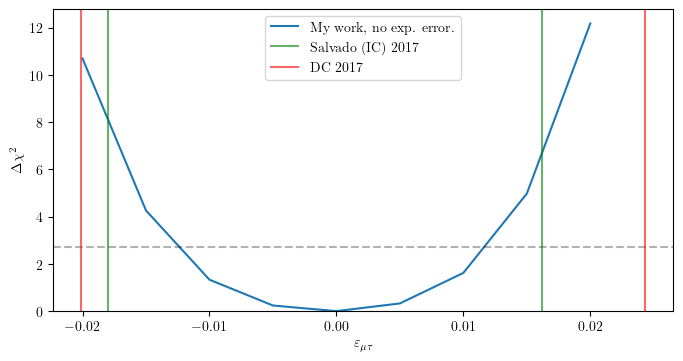

In [105]:
salvado = (-6e-3*3, 5.4e-3*3)
dc_2017 = (-6.7e-3*3, 8.1e-3*3)
plt.plot(emt_range, deltachi_emt,label='My work, no exp. error.')
#plt.plot(emt_range, deltachi1,label='My work, f=5 \%')
plt.axhline(chi2.ppf(0.9,1), alpha=0.3, c='black', ls = '--')
#plt.axhline(chi2.ppf(0.99,1), alpha=0.3, c='black', ls = '--')
plt.axvline(salvado[0], alpha=0.6,c='green', label='Salvado (IC) 2017')
plt.axvline(dc_2017[0], alpha=0.6,c='red', label='DC 2017')
plt.axvline(dc_2017[1], alpha=0.6,c='red')
plt.axvline(salvado[1], alpha=0.6,c='green')
#plt.text(0.0085,chi2.ppf(q = 0.90,df=1)+0.2,'90\% CL',rotation=0,fontsize=10,alpha = 0.5)
#plt.text(-0.0107,chi2.ppf(q = 0.99,df=1)+0.2,'99\% CL',rotation=0,fontsize=10,alpha = 0.5)
plt.ylim(bottom=0)
#plt.xlim((emt_range.min(), emt_range.max()))
plt.xlabel(r'$\varepsilon_{\mu\tau}$', fontsize=10)
plt.ylabel(r'$\Delta \chi^2$', fontsize=10)
plt.legend()

In [15]:
#s24_cl90_emt, s24_cl99_emt, emm_cl90_emt, emm_cl99_emt= s24_cl90, s24_cl99, emm_cl90, emm_cl99
s24_cl90_emm, s24_cl99_emm, emm_cl90_emm, emm_cl99_emm= s24_cl90, s24_cl99, emm_cl90, emm_cl99

Text(0.05, 0.65, '$\\pi_N = 0.25$\n$\\pi_\\theta = 0.04$\n$\\Delta \\gamma = 0.3$\n$f = 0.1$\n')

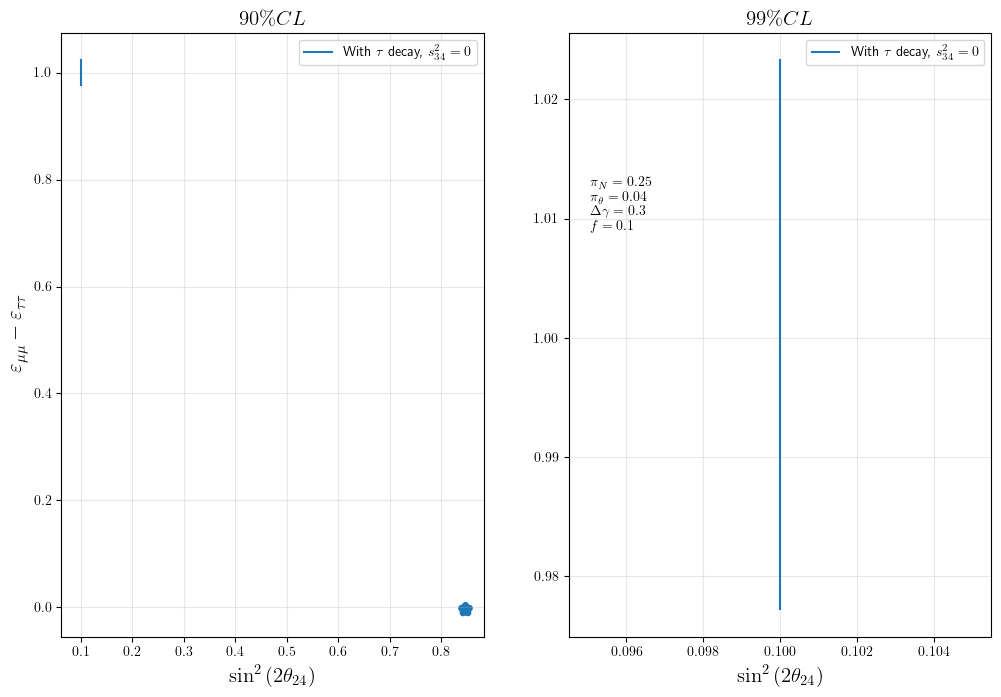

In [18]:
fig,ax = plt.subplots(1,2,figsize=(12,8))


#ax[0].plot(s24_cl90_emt, emm_cl90_emt, label=r'With $\tau$ decay, $s_{34}^2=0$ ')
ax[0].plot(s24_cl90_emm, emm_cl90_emm, label=r'With $\tau$ decay, $s_{34}^2=0$ ')


#ax[1].plot(s24_cl99_emt, emm_cl99_emt, label=r'With $\tau$ decay, $s_{34}^2=0$ ')
ax[1].plot(s24_cl99_emm, emm_cl99_emm, label=r'With $\tau$ decay, $s_{34}^2=0$ ')
#ax[0].scatter(best_fit_coords[0],best_fit_coords[1], marker='*', lw=5)
#ax[0].set_xscale('log')
#ax[1].set_xscale('log')
#ax[0].set_yscale('log')
#ax[1].set_yscale('log')
#ax[0].set_xlim((s24_range.min(), s24_range.max()))
#ax[1].set_xlim((s24_range.min(), s24_range.max()))
#ax[0].set_ylim((emm_range.min(),emm_range.max()))
#ax[1].set_ylim((emm_range.min(),emm_range.max()))
ax[0].set_xlabel('$\sin^2{(2\\theta_{24})}$', fontsize=15)
ax[1].set_xlabel('$\sin^2{(2\\theta_{24})}$', fontsize=15)
ax[0].set_ylabel(r'$\varepsilon_{\mu\mu} - \varepsilon_{\tau\tau}$', fontsize=15)
ax[0].grid(True, which='both', alpha=0.3)
ax[1].grid(True, which='both', alpha=0.3)
ax[0].set_title(r'$90\% CL$', fontsize=15)
ax[1].set_title(r'$99\% CL$', fontsize=15)

ax[0].legend()
ax[1].legend()
plt.annotate(f'$\pi_N = {sigma_a}$\n$\pi_\\theta = {sigma_b}$\n$\Delta \gamma = {gamma}$\n$f = {f}$\n', 
        xy=(0.05, 0.65), xycoords='axes fraction')
#plt.plot(best_fit_coords[0], best_fit_coords[1], marker='o', color='black')

In [27]:
# Plots for Smirnov 2013
from plotter import P_over_E_parameter
ic_params_nsi['dm_41'] = 0.93
ndim = 3
E = np.logspace(np.log10(500),4,50)
plot_params = list_of_params_nsi(ic_params_nsi, emm_range=np.array([0.06]),emt_range= np.array([-0.01,0,0.01]), s24_range=np.array([0]))
Pam = P_over_E_parameter('m', param_dict_list=plot_params, E=E, zenith = -1, ndim = ndim, anti=True, nsi=True)
Pm = P_over_E_parameter('m', param_dict_list=plot_params, E=E, zenith =-1, ndim = ndim, anti=False, nsi=True)
Pe = P_over_E_parameter('e', param_dict_list=plot_params, E=E, zenith = -1, ndim = ndim, anti=False, nsi=True)
Pae = P_over_E_parameter('e', param_dict_list=plot_params, E=E, zenith = -1, ndim = ndim, anti=True, nsi=True)

Pamam = Pam[:,1]
Pamat = Pam[:,2]
Pmm = Pm[:,1]
Pmt = Pm[:,2]
Pem = Pe[:,1]
Paeam = Pae[:,1]

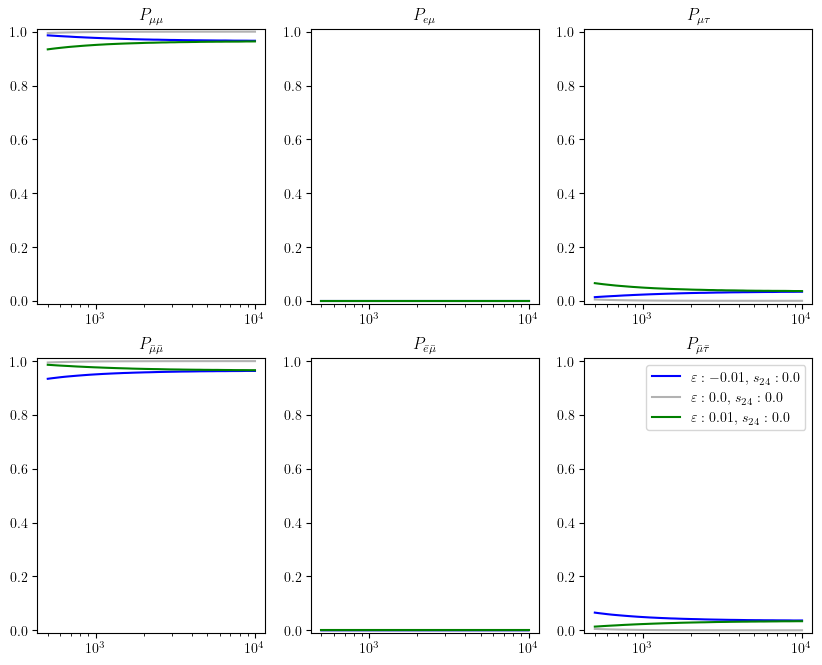

In [28]:
fig, ax = plt.subplots(2,3, figsize=(10,8))
ax = ax.flatten()
colors = ['blue','black','green']
alpha = [1,0.3,1]
for i,prob in enumerate(Pmm):
    ax[0].plot(E, prob, c=colors[i], alpha=alpha[i],label=f'$\\varepsilon: {np.round(plot_params[i]["e_mt"],3)},\, s_{{24}}: {np.round(np.sin(2*plot_params[i]["theta_24"])**2,2)}$')

for i,prob in enumerate(Pem):
    ax[1].plot(E, prob, c=colors[i],alpha=alpha[i], label=f'$\\varepsilon: {np.round(plot_params[i]["e_mt"],3)},\, s_{{24}}: {np.round(np.sin(2*plot_params[i]["theta_24"])**2,2)}$')
for i,prob in enumerate(Pmt):
    ax[2].plot(E, prob, c=colors[i],alpha=alpha[i], label=f'$\\varepsilon: {np.round(plot_params[i]["e_mt"],3)},\, s_{{24}}: {np.round(np.sin(2*plot_params[i]["theta_24"])**2,2)}$')
for i,prob in enumerate(Pamam):
    ax[3].plot(E, prob,c=colors[i],alpha=alpha[i], label=f'$\\varepsilon: {np.round(plot_params[i]["e_mt"],3)},\, s_{{24}}: {np.round(np.sin(2*plot_params[i]["theta_24"])**2,2)}$')
for i,prob in enumerate(Paeam):
    ax[4].plot(E, prob,c=colors[i],alpha=alpha[i], label=f'$\\varepsilon: {np.round(plot_params[i]["e_mt"],3)},\, s_{{24}}: {np.round(np.sin(2*plot_params[i]["theta_24"])**2,2)}$')
for i,prob in enumerate(Pamat):
    ax[5].plot(E, prob,c=colors[i],alpha=alpha[i], label=f'$\\varepsilon: {np.round(plot_params[i]["e_mt"],3)},\, s_{{24}}: {np.round(np.sin(2*plot_params[i]["theta_24"])**2,2)}$')

ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[2].set_xscale('log')
ax[3].set_xscale('log')
ax[4].set_xscale('log')
ax[5].set_xscale('log')
ax[0].set_ylim((-0.01,1.01))
ax[1].set_ylim((-0.01,1.01))
ax[2].set_ylim((-0.01,1.01))
ax[3].set_ylim((-0.01,1.01))
ax[4].set_ylim((-0.01,1.01))
ax[5].set_ylim((-0.01,1.01))
ax[0].set_title('$P_{\mu\mu}$')
ax[1].set_title('$P_{e\mu}$')
ax[2].set_title('$P_{\mu\\tau}$')
ax[3].set_title('$P_{\\bar{\mu}\\bar{\mu}}$')
ax[4].set_title('$P_{\\bar{e}\\bar{\mu}}$')
ax[5].set_title('$P_{\\bar{\mu}\\bar{\\tau}}$')
plt.legend()